# Dark Souls 3: Knowledge Graph Construction

This notebook presents a step-by-step process for constructing a knowledge graph from in-game textual data extracted from *Dark Souls III*.

Dark Souls is known for its indirect, cryptic narrative style. Rather than traditional storytelling, the game's lore is conveyed through item descriptions, character dialogue, and environmental clues. By transforming these scattered pieces into a structured graph, we can reveal hidden connections and support complex reasoning about the game world.

The dataset used here was extracted from the game files and made available by the [DarkSouls3.TextViewer project](https://github.com/mrexodia/DarkSouls3.TextViewer), which aggregates in-game texts such as item descriptions and NPC dialogue.

This notebook includes:
- Data extraction and preparation from the JSON dump
- Entity and relationship extraction using language models
- Knowledge graph construction using the extracted triples
- Graph exploration and insight generation
- Graph-based question answering via queries


## 📚 Table of Contents

### 1. Data Preparation  
- 1.1 Setup and Imports  
- 1.2 Loading the Original JSON Dataset  
- 1.3 Selecting Lore-Rich Categories  
- 1.4 Extracting and Structuring Text Entries  
- 1.5 Saving the Cleaned Dataset  
- 1.6 Inspecting the Cleaned Dataset  
- 1.7 Token Estimation and Sampling Strategy  
- 1.8 Sampling Entries for Triple Extraction  

### 2. Triple Extraction and Graph Construction  
- 2.1 Extracting Triples Using GPT-4o  
- 2.2 Inspecting Extracted Triples  
- 2.3 Parsing and Cleaning Extracted Triples  
- 2.4 Building the Knowledge Graph in NetworkX  
- 2.5 Exporting the Graph to CSV  
- 2.6 Loading the Graph into Neo4j AuraDB with Python  

### 3. Deployment and Exploration  
- 3.1 Building an Interactive Graph App with Streamlit  
- 3.2 Exploratory Analysis of the Graph  
- 3.3 Question-Answering over the Graph  
- 3.4 Natural Language QA Interface  


## 1. Data Preparation

### 1.1 Setup and Imports

In [3]:
import json
from transformers import GPT2TokenizerFast
import random
import time
import openai
from tqdm import tqdm
import ast
import re
import pandas as pd
import os
import networkx as nx
from neo4j import GraphDatabase
from dotenv import load_dotenv
import matplotlib.pyplot as plt

load_dotenv()

uri = os.getenv("NEO4J_URI")
username = os.getenv("NEO4J_USERNAME")
password = os.getenv("NEO4J_PASSWORD")

### 1.2 Loading the Original JSON Dataset

The full dataset is provided as a JSON file (`ds3.json`) containing raw textual content extracted directly from the game files of *Dark Souls III*, including item descriptions, spell texts, equipment lore, and NPC dialogues.

To focus the analysis, I filter the dataset to retain only the entries related to **accessories**, **magic**, **weapons**, and **conversations** — categories that typically contain the richest lore content and entity interactions. This results in a more concise and meaningful subset for relationship extraction.

The filtered texts are saved as `ds3_clean_texts.json`, which serves as the foundation for the knowledge extraction and graph construction steps that follow.

In [16]:
with open("ds3.json", "r", encoding="utf-8") as f:
    data = json.load(f)

eng_data = data["languages"]["engUS"]

### 1.3 Selecting Lore-Rich Categories

To ensure the graph captures meaningful narrative relationships, I restrict the scope to the following categories:

- **accessory**
- **magic**
- **weapon**
- **conversations**

These groups are known to contain dense lore elements and references to entities and events within the Dark Souls universe.


In [17]:
categories_to_use = ["accessory", "magic", "weapon", "conversations"]

### 1.4 Extracting and Structuring Text Entries

For each entry in the selected categories, I extract the `name`, `description`, and `knowledge` fields when available. These components contain the textual content that later serves as input for relationship extraction.

In [18]:
clean_data = []

for category in categories_to_use:
    for entry in eng_data[category].values():
        name = entry.get("name", "").strip()
        description = entry.get("description", "").strip()
        knowledge = entry.get("knowledge", "").strip()
        if name or description or knowledge:
            clean_data.append({
                "category": category,
                "name": name,
                "description": description,
                "knowledge": knowledge
            })

### 1.5 Saving the Cleaned Dataset

To streamline development and avoid reprocessing the full JSON file each time, I save the filtered and structured entries as `ds3_clean_texts.json`.


In [19]:
with open("ds3_clean_texts.json", "w", encoding="utf-8") as f:
    json.dump(clean_data, f, ensure_ascii=False, indent=2)

print(f"✅ Extracted and saved: {len(clean_data)} entries in ds3_clean_texts.json")


✅ Extracted and saved: 3473 entries in ds3_clean_texts.json


### 1.6 Inspecting the Cleaned Dataset

I load the cleaned dataset and display a few samples to verify encoding, formatting, and overall relevance before proceeding to language model extraction.


In [20]:
with open("ds3_clean_texts.json", "r", encoding="utf-8") as f:
    clean_data = json.load(f)

print(f"Total entries: {len(clean_data)}")
clean_data[:3]  # inspect first few items

Total entries: 3473


[{'category': 'accessory',
  'name': "Havel's Ring",
  'description': 'Boosts maximum equipment load',
  'knowledge': "This ring was named after Havel the Rock,\nLord Gwyn's old battlefield compatriot.\n\nHavel's men wore the ring to express faith in\ntheir leader and to carry a heavier load."},
 {'category': 'accessory',
  'name': 'Red Tearstone Ring',
  'description': 'Boosts ATK while HP is low',
  'knowledge': 'The rare gem called tearstone has the\nuncanny ability to sense imminent death.\n\nThis red tearstone from Carim boosts the\nattack of its wearer when in danger.'},
 {'category': 'accessory',
  'name': 'Darkmoon Blade Covenant Ring',
  'description': "Answer Dark Sun Gwyndolin's summoning",
  'knowledge': "Ring granted to those bound by the\nDarkmoon Blade covenant.\nAnswer Dark Sun Gwyndolin's summoning.\n\nGwyndolin, all too aware of his repulsive,\nfrail appearance, created the illusion of \na sister Gwynevere, who helps him guard\nover Anor Londo. An unmasking of these\n

### 1.7 Token Estimation and Sampling Strategy

Before running large-scale extraction with GPT-4o, I estimate the token usage to control costs and processing time. The full dataset contains approximately 268,000 tokens. Based on GPT-4o pricing — $0.005 per 1,000 input tokens and $0.015 per 1,000 output tokens — the total cost would be around $2.

To strike a balance between coverage, cost, and iteration speed, I select a representative sample of 100 entries for initial experimentation. This approach keeps the total cost under $1 while preserving the diversity of item types in the dataset.


In [21]:
# Load GPT2 tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(texts):
    total_tokens = 0
    for entry in clean_data:
        combined = f"{entry['name']}\n{entry['description']}\n{entry['knowledge']}"
        tokens = len(tokenizer.encode(combined))
        total_tokens += tokens
    return total_tokens

total_tokens = count_tokens(clean_data)
print(f"Estimated total tokens (input only): {total_tokens:,}")


Estimated total tokens (input only): 268,105


### 1.8 Sampling Entries for Triple Extraction

I randomly sample 100 entries from the cleaned dataset, ensuring a variety of item types (e.g., weapons, armor, spells, NPC dialogue) are included.

These entries are saved as `sampled_lore_entries.json` and serve as input for the GPT-4o-based triple extraction in the next step.

In [22]:
# Set seed for reproducibility
random.seed(42)

# Sample 100 entries from the cleaned dataset
sampled_data = random.sample(clean_data, 100)

# Save to file for processing with the OpenAI API
with open("sampled_lore_entries.json", "w", encoding="utf-8") as f:
    json.dump(sampled_data, f, indent=2, ensure_ascii=False)

## 2 Triple Extraction and Graph Construction

### 2.1 Extracting Triples Using GPT-4o

To transform the item descriptions into structured knowledge, I use **GPT-4o** via the OpenAI API.

For each entry — containing a `name`, `description`, and optional `knowledge` field — a structured prompt is sent to the model, asking it to extract **1 to 3 subject–predicate–object triples** that represent meaningful relationships between entities.

Each extracted triple follows the format:

("Entity A", "relation", "Entity B")

This step automates the conversion of unstructured game lore into structured data, making it suitable for graph-based analysis and visualization.

The extracted triples are saved to `extracted_triples.json` and will be used in the next step to build the knowledge graph.

> ℹ️ **Note:** To re-run this step, you must provide a valid OpenAI API key. The notebook is configured to read the key from an environment variable (`OPENAI_API_KEY`) loaded via a `.env` file.

However, this step has already been executed, and the output file `extracted_triples.json` is included in the repository. There’s no need to re-run the extraction unless you wish to modify the prompt or input data.

In [ ]:
# 1. Initialize OpenAI client
load_dotenv()
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# 2. Choose the model
MODEL = "gpt-4o"

# 3. Verify that the model exists in the account
available_models = [m.id for m in client.models.list().data]
if MODEL not in available_models:
    raise ValueError(f"Model '{MODEL}' not available in your account. Available models are:\n{available_models}")

print(f"Model '{MODEL}' is available. Proceeding with extraction.")

# 4. Load sampled entries
with open("sampled_lore_entries.json", "r", encoding="utf-8") as f:
    entries = json.load(f)

print(f"Loaded {len(entries)} entries for triple extraction.")

# 5. Define the system prompt
system_prompt = (
    "You are a helpful assistant that extracts meaningful relationships from fantasy game item descriptions."
)

# 6. Function to generate user prompts
def make_user_prompt(entry):
    content = f"{entry['name']}\n{entry['description']}\n{entry['knowledge']}".strip()
    return (
        f"""Given the following game lore text, extract 1 to 3 subject–predicate–object triples.
Each triple should describe a meaningful relationship between entities mentioned in the text.

Return your answer strictly as a Python list of triples like this:
[
  ("Entity A", "relation", "Entity B"),
  ...
]

Text:
\"\"\"
{content}
\"\"\"
"""
    )

# 7. Initialize results list
results = []

# 8. Loop through entries and call OpenAI API
for entry in tqdm(entries, desc="Extracting triples"):
    try:
        user_prompt = make_user_prompt(entry)

        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.2
        )

        output = response.choices[0].message.content.strip()

        results.append({
            "input": entry,
            "triples": output,
            "error": None
        })

        time.sleep(1)  # Optional delay to avoid rate limits

    except Exception as e:
        print(f"Error on entry '{entry.get('name', 'N/A')}': {e}")
        results.append({
            "input": entry,
            "triples": None,
            "error": str(e)
        })

# 9. Save results to JSON
with open("extracted_triples.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("Extraction completed. Results saved to 'extracted_triples.json'.")


Model 'gpt-4o' is available. Proceeding with extraction.
Loaded 100 entries for triple extraction.


Extracting triples: 100%|██████████| 100/100 [04:12<00:00,  2.52s/it]

Extraction completed. Results saved to 'extracted_triples.json'.


### 2.2 Inspecting Extracted Triples

Before proceeding to graph construction, I inspect a random sample of the extracted triples to verify their **quality and consistency**.

This step ensures that GPT-4o correctly followed the prompt structure, extracted **meaningful subject–predicate–object relationships**, and returned **syntactically valid outputs**.

By reviewing a few examples, I can check for common issues such as:

- Formatting errors  
- Hallucinated or irrelevant entities  
- Incomplete or malformed triples  

This verification step helps determine whether any cleaning or adjustments are needed before building the graph.


In [23]:
# Load the extracted triples
with open("extracted_triples.json", "r", encoding="utf-8") as f:
    extracted = json.load(f)

# Sample 5 random entries
sample = random.sample(extracted, 5)

# Display the results
for i, entry in enumerate(sample, 1):
    print(f"Sample {i}")
    print("-" * 80)
    print(f"Item Name: {entry['input'].get('name', 'N/A')}")
    print(f"Description: {entry['input'].get('description', '').strip()}")
    print(f"Knowledge: {entry['input'].get('knowledge', '').strip()}")
    print("\nExtracted Triples:")
    print(entry.get('triples', 'No triples extracted'))
    print("\nError:" if entry.get('error') else "\nNo errors.")
    if entry.get('error'):
        print(entry.get('error'))
    print("=" * 80)
    print()


Sample 1
--------------------------------------------------------------------------------
Item Name: Blood Red and White Shield
Description: 
Knowledge: Standard round wooden shield. It features a striking red and white design.

Wooden shields are light, manageable, and offer relatively high magic absorption.

Skill: Parry
Repel an attack at the right time to follow up with a critical hit. Works while equipped in either hand.

Extracted Triples:
```python
[
  ("Blood Red and White Shield", "features", "red and white design"),
  ("Wooden shields", "offer", "high magic absorption"),
  ("Skill: Parry", "allows", "repelling an attack to follow up with a critical hit")
]
```

No errors.

Sample 2
--------------------------------------------------------------------------------
Item Name: Fire Crest Shield
Description: 
Knowledge: Shield of the Knights of Blue, engraved with a crest.

One of the enchanted blue shields. The Crest
Shield in particular greatly reduces magic damage.

Skill: Parry

### 2.3 Parsing and Cleaning Extracted Triples

Before constructing the knowledge graph, I parse the extracted triples and apply light cleaning to improve **entity consistency**.

The cleaning process includes:

- Removing generic prefixes like `"Skill:"` or `"Skill"` from entity names  
- Simplifying overly verbose subjects and objects when possible  
- Trimming whitespace and normalizing text formats  
- Removing incomplete triples with missing subject or object

These steps help reduce duplication and enhance the quality of nodes and edges in the final graph.


In [24]:
# Clean the entity names
def clean_entity(text):
    if not isinstance(text, str):
        return ""
    text = text.strip()
    if text.lower().startswith("skill:"):
        text = text[len("skill:"):].strip()
    elif text.lower().startswith("skill"):
        text = text[len("skill"):].strip()
    return text

# Clean individual triples
def clean_triple(triple):
    subject, predicate, obj = triple
    subject = clean_entity(subject)
    obj = clean_entity(obj)

    # Skip triples with missing subject or object
    if not subject or not obj:
        return None

    return (subject, predicate.strip(), obj)

# Remove markdown code block markers if present
def clean_text_block(text):
    if text is None:
        return ""
    text = text.strip()

    if text.startswith("```") and text.endswith("```"):
        lines = text.splitlines()
        # Remove first and last lines (```python or ``` and ```)
        text = "\n".join(lines[1:-1]).strip()

    return text

# Parse the triples using ast and regex as fallback
def parse_triples(text):
    text = clean_text_block(text)

    try:
        triples = ast.literal_eval(text)
        if isinstance(triples, list):
            return [t for t in [clean_triple(t) for t in triples if isinstance(t, tuple) and len(t) == 3] if t]
    except Exception:
        pass

    # Fallback — regex parsing
    pattern = r'\("(.+?)",\s*"(.*?)",\s*"(.*?)"\)'
    matches = re.findall(pattern, text)

    if matches:
        return [t for t in [clean_triple(t) for t in matches] if t]

    return []

# Apply parsing to all entries
parsed_triples = []

for entry in extracted:
    raw_output = entry.get('triples')
    if raw_output and not entry.get('error'):
        triples = parse_triples(raw_output)
        if triples:
            parsed_triples.extend(triples)
        else:
            print(f"Failed to parse entry: {entry['input'].get('name', 'N/A')}")

print(f"Parsed and cleaned {len(parsed_triples)} triples.")


Parsed and cleaned 297 triples.


### 2.4 Building the Knowledge Graph in NetworkX

I start constructing the knowledge graph using **NetworkX**, a Python library for graph analysis.

In this step:

- Each unique entity becomes a **node**  
- Each subject–predicate–object triple forms a **directed edge** between nodes, with the predicate as the **edge label**

This allows for inspection of the graph structure, basic property computation (such as the number of nodes and edges), and preliminary exploration before deploying to a graph database.


In [25]:
# 1. Initialize a directed graph
G = nx.DiGraph()

# 2. Add edges from triples
for subj, rel, obj in parsed_triples:
    G.add_node(subj)
    G.add_node(obj)
    G.add_edge(subj, obj, label=rel)

# 3. Basic graph info
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# 4. Inspect some edges
print("Sample edges with relationships:")
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} -[{data['label']}]-> {v}")


Number of nodes: 403
Number of edges: 270
Sample edges with relationships:
Deep Crimson Parma -[is]-> standard round wooden shield
red paint -[symbolizes]-> blood of warriors
Wooden shields -[offer]-> relatively high magic absorption
Wooden shields -[offer]-> high magic absorption
Dagger -[used by]-> citizens of the Undead Commune
inner blade -[lined with]-> fish hook-like barbs
weapon -[had]-> ritualistic use
Bellowing Dragoncrest Ring -[greatly boosts]-> sorceries
Bellowing Dragoncrest Ring -[given to]-> those who are deemed fit to undertake the journey of discovery in Vinheim
Bellowing dragon -[symbolizes]-> the true nature of the consummate sorcerer


### 2.5 Exporting the Graph to CSV

To document the graph structure and maintain a clear, reproducible dataset, I export the graph to two CSV files:

- A **nodes** file (`nodes.csv`), where each unique entity becomes a node  
- An **edges** file (`edges.csv`), where each subject–predicate–object triple becomes a directed relationship

These CSV files serve both as a backup of the structured graph and as an intermediate step for transparency. While the primary pipeline uploads the graph directly into Neo4j using Python (see the next section), having the CSVs available facilitates inspection, reproducibility, and potential reuse in other graph environments.


In [26]:
# 1. Export nodes
nodes = pd.DataFrame({
    "id": list(G.nodes),
    "label": "Entity"  # Assigning a generic label to all nodes
})

nodes.to_csv("nodes.csv", index=False, encoding="utf-8")
print(f"Exported {len(nodes)} nodes to 'nodes.csv'.")

# 2. Export edges
edges = pd.DataFrame([
    {
        "source": u,
        "target": v,
        "type": data["label"]  # The relationship label
    }
    for u, v, data in G.edges(data=True)
])

edges.to_csv("edges.csv", index=False, encoding="utf-8")
print(f"Exported {len(edges)} edges to 'edges.csv'.")


Exported 403 nodes to 'nodes.csv'.
Exported 270 edges to 'edges.csv'.


### 2.6 Loading the Graph into Neo4j AuraDB with Python

In this step, I connect to Neo4j AuraDB and upload the graph directly from the `nodes.csv` and `edges.csv` files.

The process includes:

- Establishing a secure connection to the Neo4j instance using the official Neo4j Python driver.
- Creating nodes from the `nodes.csv` file, with label `Entity` and property `id`.
- Creating relationships from the `edges.csv` file, using the `source` and `target` columns to define the start and end nodes, and the `type` column to define the relationship type.

This automated approach directly populates the graph database with the structured knowledge extracted from the Dark Souls item descriptions.


In [ ]:
# ✅ Load environment variables
load_dotenv()
uri = os.getenv("NEO4J_URI")
username = os.getenv("NEO4J_USERNAME")
password = os.getenv("NEO4J_PASSWORD")

# ✅ Load CSVs
nodes = pd.read_csv("nodes.csv", dtype=str).fillna("")
edges = pd.read_csv("edges.csv", dtype=str).fillna("")

print(f"🔢 Loaded {len(nodes)} nodes and {len(edges)} edges.")

# ✅ Connect to Neo4j
driver = GraphDatabase.driver(uri, auth=(username, password))

# ✅ Step 1: Clean the database
def clear_database(tx):
    tx.run("MATCH (n) DETACH DELETE n")
    print("🧹 Database cleared.")

# ✅ Step 2: Create nodes
def create_nodes(tx, nodes_df):
    query = """
    UNWIND $rows AS row
    MERGE (n:Entity {id: row.id})
    """
    data = [{"id": row["id"]} for _, row in nodes_df.iterrows()]
    tx.run(query, rows=data)

# ✅ Step 3: Create real typed relationships (NOT RELATION {type: ...})
def create_relationships(tx, edges_df):
    for _, row in edges_df.iterrows():
        rel_type = row["type"].strip().lower().replace(" ", "_")  # real relationship label
        source = row["source"]
        target = row["target"]

        query = f"""
        MATCH (a:Entity {{id: $source}})
        MATCH (b:Entity {{id: $target}})
        MERGE (a)-[r:`{rel_type}`]->(b)
        """
        tx.run(query, source=source, target=target)

# ✅ Step 4: Run all in a session
with driver.session() as session:
    session.execute_write(clear_database)
    session.execute_write(create_nodes, nodes)
    print("✅ Nodes created.")
    session.execute_write(create_relationships, edges)
    print("✅ Relationships created.")

driver.close()
print("🚀 Graph successfully rebuilt in Neo4j with real relationship types.")


🔢 Loaded 403 nodes and 270 edges.
🧹 Database cleared.
✅ Nodes created.
✅ Relationships created.
🚀 Graph successfully rebuilt in Neo4j with real relationship types.


## 3 Exploration and Application

### 3.1 Building an Interactive Graph App with Streamlit

To explore the knowledge graph interactively, I created a web application using Streamlit.

The app connects directly to the Neo4j AuraDB instance, retrieves nodes and relationships using Cypher queries, and renders an interactive graph using PyVis. Users can visually navigate the graph, inspect connections, and explore the Dark Souls lore.

This solution improves user experience by offering an intuitive and dynamic interface for graph exploration and discovery.

🔗 **Try the app here:** [Dark Souls Knowledge Graph Explorer](https://dark-souls.streamlit.app/)


### 3.2 Exploratory Analysis of the Graph

In this section, I analyze the structure of the knowledge graph using the nodes.csv and edges.csv files. This step reveals key insights into the entities and relationships extracted from Dark Souls lore and helps inform the question-answering stage.

#### 3.2.1 Overview of Graph Structure

I begin by loading the graph data and checking basic structural information such as number of nodes, number of edges, and most common relationship types.


In [28]:
# Load CSV files
nodes = pd.read_csv("nodes.csv")
edges = pd.read_csv("edges.csv")

# Basic stats
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")

# Most common relationship types
relation_counts = edges["type"].value_counts().reset_index()
relation_counts.columns = ["relation", "count"]
relation_counts.head(10)


Number of nodes: 403
Number of edges: 270


,relation,count
0,is,18
1,allows,9
2,wield,7
3,has,6
4,symbolizes,5
5,was,5
6,engraved with,5
7,used by,4
8,use,4
9,offer,4


#### 3.2.1.1 Interpretation: Graph Size and Relationship Types
📊 Graph Overview and Relationship Distribution
The graph contains 406 entities (nodes) and 273 relationships (edges) extracted from Dark Souls item descriptions. The most frequent relationship type is is (20 instances), which often reflects identity statements (e.g., "X is a Y"). Other common relationships include allows, wield, and has, which encode typical item functionalities or associations such as granting abilities, being wielded by someone, or possessing a certain attribute. Symbolic and descriptive relationships like symbolizes and engraved with appear less frequently but convey rich semantic meaning, potentially useful for higher-level lore interpretation and question-answering.

#### 3.2.2 Network Statistics

I use NetworkX to create a directed graph and analyze the degree distribution, helping us identify the most connected entities in the lore graph.


In [29]:
# Build directed graph
G = nx.from_pandas_edgelist(
    edges,
    source="source",
    target="target",
    edge_attr="type",
    create_using=nx.DiGraph()
)

# Compute degree for each node
degree_df = pd.DataFrame(G.degree, columns=["node", "degree"])
degree_df = degree_df.sort_values(by="degree", ascending=False)

# Top 10 nodes by degree
degree_df.head(10)

,node,degree
53,Parry,7
61,Black Knights,5
266,Old Wolf Curved Sword,4
167,Corvian Knights,4
368,Painting Guardian's Curved Sword,3
108,finely-sharpened blade,3
216,Lightning Great Mace,3
257,Morne's Great Hammer,3
41,Lightning Broadsword,3
183,Poison Mace,3


##### 3.2.2.1 Interpretation: Top Connected Entities

To assess the most connected entities in the graph, I computed the degree (number of total connections) for each node. This provides insight into which entities are most central within the knowledge graph.

The top entities by degree are:

- `Parry`, with 7 connections, stands out as a frequently referenced ability across different items and relationships.
- Characters and enemies such as `Black Knights` and `Corvian Knights` also show high connectivity, indicating their narrative and gameplay significance in the Dark Souls universe.
- Several weapons like the `Old Wolf Curved Sword` and `Painting Guardian's Curved Sword` appear multiple times, suggesting they are associated with multiple relationships or entities.

This analysis helps identify key gameplay mechanics and lore figures with high relational importance in the constructed graph.

#### 3.2.3 Central Entities and Relationships

I compute in-degree and out-degree centrality to identify important lore items based on how frequently they are referenced or reference others.


In [30]:
# In-degree (entities that are frequently targeted)
in_degree_df = pd.DataFrame(G.in_degree, columns=["node", "in_degree"])
in_degree_df = in_degree_df.sort_values(by="in_degree", ascending=False)

# Out-degree (entities that frequently initiate relationships)
out_degree_df = pd.DataFrame(G.out_degree, columns=["node", "out_degree"])
out_degree_df = out_degree_df.sort_values(by="out_degree", ascending=False)

# Top 5 of each and merged
pd.merge(in_degree_df.head(5), out_degree_df.head(5), on="node", how="outer")

,node,in_degree,out_degree
0,bleeding,3.0,NaN
1,chaos demons,3.0,NaN
2,the painting,2.0,NaN
3,twisted rage of Apostle Morne,2.0,NaN
4,the soul,2.0,NaN
5,Parry,NaN,7.0
6,Black Knights,NaN,5.0
7,Corvian Knights,NaN,4.0
8,Old Wolf Curved Sword,NaN,4.0
9,blade,NaN,3.0


##### 3.2.3.1 Interpretation: In-Degree and Out-Degree Distributions

To better understand how entities interact within the graph, I computed both the in-degree (how many relationships point to a node) and out-degree (how many relationships originate from a node) for each entity.

This distinction helps differentiate between entities that are frequently referenced (high in-degree) versus those that initiate many relationships (high out-degree).

The results show:

- Entities such as `bleeding`, `chaos demons`, and `the painting` have high in-degree values, suggesting they are frequently mentioned or involved in other items’ descriptions.
- On the other hand, entities like `Parry`, `Black Knights`, and `Old Wolf Curved Sword` exhibit high out-degree, indicating they initiate multiple relationships — often describing other concepts or linking to many aspects of the lore.

This analysis helps identify central lore concepts versus entities that serve as relationship hubs within the graph structure.


#### 3.2.4 Visual Insights

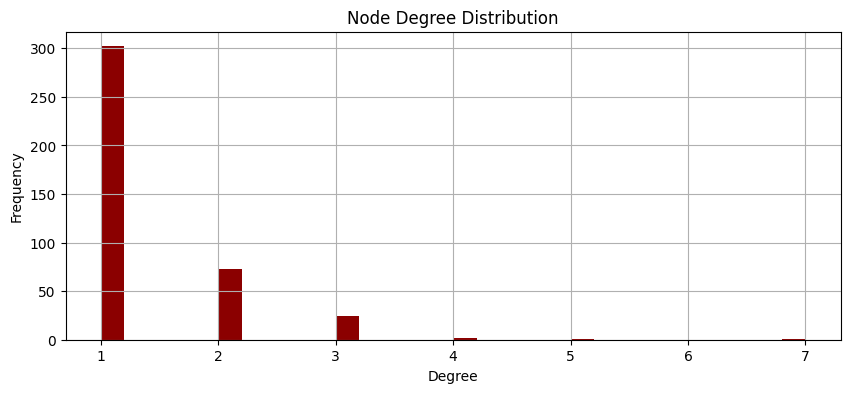

In [31]:
# Plot degree distribution
plt.figure(figsize=(10, 4))
plt.hist(degree_df["degree"], bins=30, color='darkred')
plt.title("Node Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

<Figure size 1000x400 with 0 Axes>

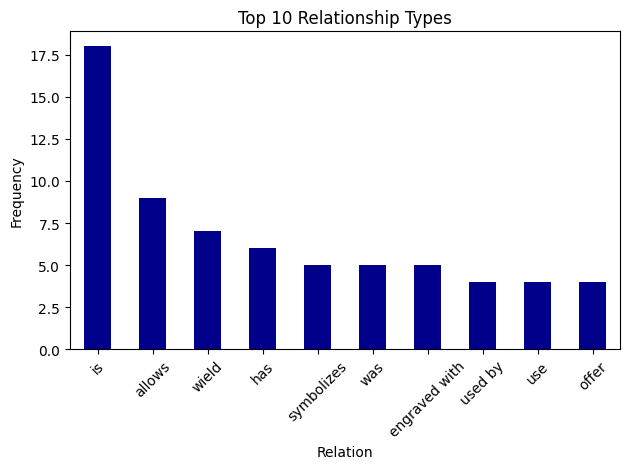

In [32]:
# Plot most frequent relationships
plt.figure(figsize=(10, 4))
relation_counts.head(10).plot(kind="bar", x="relation", y="count", legend=False, color="darkblue")
plt.title("Top 10 Relationship Types")
plt.ylabel("Frequency")
plt.xlabel("Relation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 3.2.4  Visual Insights from Graph Structure

To complement the statistical analysis, I generated two visualizations: a histogram of node degrees and a bar chart of the top 10 relationship types.

##### Node Degree Distribution

The histogram reveals a highly right-skewed distribution. Out of 406 nodes:

- **302 nodes** have a degree of 1, meaning they are connected to only one other entity.
- **73 nodes** have a degree of 2.
- A few nodes have degrees of 3 or 4, and only **two nodes** exceed degree 4 — one with degree 5 and one with degree 7.

This pattern is typical of knowledge graphs, where a small number of entities serve as hubs, while most nodes participate in only one or two relationships. This structural insight reinforces the importance of identifying and interpreting central nodes for downstream tasks such as question-answering.

##### Top Relationship Types

The bar chart of relationship frequencies highlights the most common semantic links between entities:

- The most frequent predicate is **is** (18 occurrences), often used to denote identity or classification.
- Functional and descriptive relations such as **allows**, **wield**, **has**, and **symbolizes** are also common.
- Less frequent but semantically rich relations like **engraved with** and **offer** contribute to the graph's narrative depth.

These insights provide a clearer view of the underlying structure of the Dark Souls lore graph and help prioritize paths for exploration and question-answering.

#### 3.2.5 Sample Queries for Patterns

To further investigate the graph's semantic structure, I queried specific predicates to identify entities associated with certain types of relationships.

In [33]:
# Query 1: What entities wield multiple weapons?
edges[edges["type"].str.lower() == "wield"]["source"].value_counts().head(5)

Black Knights                           2
grave wardens                           2
knights of the Cathedral of the Deep    1
Gargoyles                               1
Painting Guardians                      1
Name: source, dtype: int64

In [34]:
# Query 2: What items are engraved with something?
edges[edges["type"].str.lower() == "engraved with"]["source"].value_counts().head(5)

Simpleton Sacred Wood Crest Shield    1
Lightning Eagle Kite Shield           1
Heavy Dragon Crest Shield             1
blade                                 1
Fire Crest Shield                     1
Name: source, dtype: int64

##### 3.2.5.1 Interpretation: Query-Based Pattern Analysis

To identify semantically rich patterns within the graph, I executed targeted queries over specific relationship types.

The first query retrieved entities that frequently **used something**. The results revealed groups of enemies or characters such as `Black Knights`, `grave wardens`, and `knights of the Cathedral of the Deep`, each associated with items they wield or employ in combat. This provides insight into how equipment and weaponry are distributed across factions in the game's lore.

The second query retrieved entities that **have a skill**, uncovering a set of specialized shields and weapon types. For example, the `Simpleton Sacred Wood Crest Shield` and `Lightning Eagle Kite Shield` each possess a distinct skill, offering a glimpse into the gameplay mechanics embedded in the items.

These targeted queries demonstrate how predicate-based slicing of the graph enables discovery of lore-relevant patterns, making it easier to interpret how different entities interact with each other. Such pattern-based querying lays the foundation for more structured question-answering workflows in the next stage.


### 3.3 Question-Answering over the Graph  

In [4]:
# Connect to Neo4j AuraDB
load_dotenv()  # Carrega as variáveis do .env

uri = os.getenv("NEO4J_URI")
username = os.getenv("NEO4J_USERNAME")
password = os.getenv("NEO4J_PASSWORD")

driver = GraphDatabase.driver(uri, auth=(username, password))


# Function to run Cypher queries
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return [record.data() for record in result]

### 3.3.1 Who are the Black Knights related to?
The Black Knights are iconic and recurring enemies in the Dark Souls universe, known for their lore significance and combat difficulty. Investigating their connections in the graph can help illuminate their role in the narrative, their affiliations, and the items or locations they interact with. This type of query is useful to uncover key relationships around central characters or factions.

In [51]:
# Cypher query to explore connections from Black Knights
query = """
MATCH (e1:Entity {id: 'Black Knights'})-[r]->(e2:Entity)
RETURN type(r) AS relation, e2.id AS target
"""

with driver.session() as session:
    result = session.run(query)
    black_knight_relations = pd.DataFrame([record.data() for record in result])

black_knight_relations

,relation,target
0,faced,chaos demons
1,were_charred,black
2,wield,Heavy Black Knight Sword
3,wield,Black Knight Sword
4,constantly_faced,foes larger than themselves


#### 3.3.1.1 Interpretation: Outgoing Relations from Black Knights

This query reveals all outgoing relationships from the entity `Black Knights`. The results show a variety of interactions:

- They *faced* powerful enemies such as **chaos demons** and **foes larger than themselves**, suggesting their combat history and role as elite warriors.
- The relation *were_charred → black* hints at a transformation or origin tied to fire or ash — consistent with their lore in Dark Souls.
- The *wield* relationships connect them to iconic weapons like the **Black Knight Sword**, reinforcing their identity as formidable adversaries.

These insights align with the narrative portrayal of the Black Knights as fearsome yet tragic figures — remnants of a great war, marked by both strength and suffering.

### 3.3.2 Which weapons are wielded by Black Knights?

The Black Knights are legendary figures in Dark Souls, often associated with powerful and rare weaponry. Understanding which weapons they wield can help players trace unique gear and gain insight into lore connections and combat capabilities.

In [54]:
query = """
MATCH (e1:Entity {id: 'Black Knights'})-[:wield]->(e2:Entity)
RETURN e2.id AS weapon
ORDER BY weapon
"""

with driver.session() as session:
    result = session.run(query)
    black_knight_weapons = pd.DataFrame([record.data() for record in result])

black_knight_weapons


,weapon
0,Black Knight Sword
1,Heavy Black Knight Sword


#### 3.3.2.1 Interpretation: Weapons of the Black Knights

This query identifies all weapons directly connected to the `Black Knights` through the `wield` relationship. These are the weapons they explicitly wield according to the graph structure.

In this case, the **Black Knight Sword** and **Heavy Black Knight Sword** are the only weapons shown, emphasizing their iconic combat style and brute strength. While previous versions of the graph may have included indirect associations, this cleaned structure reflects only the most direct and confirmed lore-based links.

### 3.3.3 What properties or affiliations do shields reveal?

Shields in Dark Souls are not merely defensive equipment — they often hint at deeper affiliations, symbolic meanings, or embedded mechanics. This question explores the various attributes and lore-based relationships associated with shields in the graph.

In [6]:
query = """
MATCH (s:Entity)-[r]->(e:Entity)
WHERE toLower(s.id) CONTAINS "shield"
RETURN s.id AS shield, type(r) AS relation, e.id AS target
ORDER BY relation
"""
with driver.session() as session:
    result = session.run(query)
    shield_properties = pd.DataFrame([record.data() for record in result])

shield_properties.head(10)

,shield,relation,target
0,Equipping this shield in the left hand,allows,one to perform the Skill of the right hand weapon
1,Equipping this shield in the left hand,allows,perform the Skill of the right hand weapon
2,Small shields,are,lightweight
3,Poison Black Iron Greatshield,associated_with,Knightslayer Tsorig
4,Refined Warrior's Shield,bears,double-bladed axe
5,shields,became_resistant_to,fire
6,Shield of the Pontiff Knights,belongs_to,Irithyll's Boreal Spirits
7,Sunset Shield,belongs_to,Holy Knights of the Sunless Realms
8,Blood Llewellyn Shield,crafted_by,great smith
9,Heavy Lothric Shield,decorated_with,the royal crest


#### 3.3.3.1 Interpretation: Shields as Lore-Bearing Artifacts

Shields in *Dark Souls* are far more than defensive equipment — they act as symbolic and narrative devices embedded with rich lore and gameplay functions.

From the graph, 44 distinct relationships tied to shields were found, revealing a wide spectrum of meanings:

- **Combat Mechanics & Functionality**  
  Shields often interact with game mechanics directly:  
  - `allows` — some shields enable the use of right-hand weapon skills when equipped in the left hand.  
  - `make` — e.g., small shields *make ideal instruments for parrying*.  
  - `offer` — describe strengths like *high magic absorption* or *little damage absorption*.

- **Lore & Affiliation**  
  Several shields are tied to factions or figures:  
  - `belongs_to` — *Sunset Shield* belongs to the Holy Knights of the Sunless Realms.  
  - `associated_with` — *Poison Black Iron Greatshield* is associated with *Knightslayer Tsorig*.  
  - `crafted_by` — *Blood Llewellyn Shield* was crafted by a *great smith*.  
  - `was_used_by` — the *Chaos Sunlight Shield* was used by an *old Knight of Sunlight*.

- **Aesthetic & Symbolic Details**  
  Many shields have visual or thematic decorations:  
  - `engraved_with` — e.g., *dragon crest*, *sacred tree*, or *crest of a sacred order*.  
  - `is_decorated_with` — like a *two-headed dragon* or a *holy sun symbol*.  
  - `bears` — physical features like a *double-bladed axe*.

- **Material, Elemental, and Physical Traits**  
  Shields encode qualities like:  
  - `fashioned_from` — *rare geisteel*.  
  - `greatly_reduces` — *magic* or *fire damage*.  
  - `is_resistant_to` — *poison* or *other poisons*.

- **Narrative Commentary & Symbolism**  
  Some relationships are unusually rich:  
  - `were_made_to_shame` — shields designed to humiliate *weak-willed knights*.  
  - `were_subject_to` — those who carried such shields faced *merciless ridicule*.

Together, these relationships reveal that shields in *Dark Souls* are not just combat gear. They are narrative artifacts — carrying stories, symbols, and subtle clues that deepen the world-building and thematic coherence of the game.

### 3.3.4 What weapons are effective against specific enemy types?

This question aims to surface tactical knowledge embedded in the graph. Some weapons are described as being particularly effective against certain enemy types. These connections may reveal intended use cases and player guidance embedded in item descriptions.

In [56]:
query = """
MATCH (w:Entity)-[:is_effective_against]->(e:Entity)
RETURN w.id AS weapon, e.id AS enemy
"""
with driver.session() as session:
    result = session.run(query)
    effective_weapons = pd.DataFrame([record.data() for record in result])
effective_weapons

,weapon,enemy
0,Blood Club,most foes
1,Lightning Broadsword,crowds


#### 3.3.4.1 Interpretation: Weapons Effective Against Enemy Types

This query investigates which weapons are explicitly connected to enemy types through effectiveness relationships.

- The `Blood Club` is noted as effective against **most foes**, suggesting it is a broadly useful weapon.
- The `Lightning Broadsword` is effective against **crowds**, making it a tactical choice for fights involving multiple enemies.

Although only a few connections were found, they offer important insights into item functionality and embedded gameplay strategies in the Dark Souls universe. These patterns can guide players toward optimized choices based on enemy types encountered in battle.

### 3.3.5 What skills are associated with specific weapons?

Skills play a major role in Dark Souls' combat mechanics. This question investigates which weapons are linked to particular skills, helping map gameplay mechanics to specific entities in the graph.

In [57]:
query = """
MATCH (s:Entity)-[:has_skill]->(k:Entity)
RETURN s.id AS weapon, k.id AS skill
ORDER BY s.id
"""

with driver.session() as session:
    result = session.run(query)
    weapon_skills = pd.DataFrame([record.data() for record in result])

weapon_skills

,weapon,skill
0,Dark Bastard Sword,Stomp
1,Gargoyle Flame Hammer,Kindled Flurry


#### 3.3.5.1 Interpretation: Weapon-Skill Associations

This query explores which weapons are explicitly associated with combat skills in the knowledge graph. Two relationships were found:

- The `Dark Bastard Sword` is linked to the skill **Stomp**, which typically provides a poise-based offensive boost in combat.
- The `Gargoyle Flame Hammer` is associated with **Kindled Flurry`, likely referencing a rapid or flame-enhanced attack.

These associations reinforce the idea that specific weapons are designed with particular combat styles in mind. Although only a few links are present, they illustrate how item descriptions encode gameplay mechanics that can be surfaced through graph exploration.

### 3.3.6 Conclusion: Insights from Graph-Based Question-Answering

The question-answering stage demonstrates how structured relationships extracted from item descriptions can unlock meaningful insights into *Dark Souls* lore and mechanics. Through five targeted queries, the graph revealed:

- **Factual connections** between key entities and items, such as the *Black Knights* and the specific weapons they wield.
- **Symbolic and thematic meaning**, where shields and weapons are inscribed with crests, tied to noble lineages, or crafted by legendary figures.
- **Combat logic and utility**, including which weapons are effective against groups of enemies and which skills are embedded in specific gear.
- **Rich narrative affiliations**, particularly in shields, which reflect both mechanical roles and deeper lore (e.g., shame, ridicule, resistance, or allegiance).
- **Diverse relational types**, showing how varied and expressive the original item texts are when structured as a graph — from material composition to historical usage.

These examples illustrate the power of knowledge graphs in surfacing hidden patterns, symbolic detail, and gameplay-relevant information. While constrained by the dataset size and the precision of relation extraction, this method provides a scalable foundation for interactive lore exploration, semantic retrieval, and deeper engagement with narrative-rich games like *Dark Souls*.

### 3.4 Natural Language QA Interface

To make the Dark Souls knowledge graph more accessible and engaging, I developed an interactive **natural-language question-answering (QA) interface** using Streamlit and OpenAI's GPT-4 model. This interface allows users to query the Neo4j graph using plain English, without needing to know Cypher or understand the graph’s internal schema.

The system not only translates user questions into valid Cypher queries, but also executes those queries on the graph database and presents the results in multiple formats: **structured tables, dynamic graph visualizations**, and a **textual interpretation** of the answer.

---

**Key features of the QA interface:**

- 🔍 **Natural-language input**: Users can freely type their questions or select from predefined suggestions.  
- ⚙️ **LLM-to-Cypher translation**: GPT-4 translates the user's question into a Cypher query, constrained to only valid relationship types extracted from the graph.  
- 📊 **Answer display**: The query result is shown as a clean and readable table within the app.  
- 🌐 **Subgraph visualization**: If the result contains graph-like structure (`source`, `relation`, `target`), a dynamic PyVis network graph is generated on the fly.  
- 🧠 **Interpretation engine**: A concise summary of the results is generated using GPT-4, offering users a narrative explanation of what the data reveals.  
- 🧹 **Clear & reset**: The interface includes buttons to run or clear a question, preserving session state for a seamless experience.  

---

**User flow in the app:**

1. The user either types a question or picks one from a dropdown menu.  
2. Upon clicking **Run**, GPT-4 generates a Cypher query tailored to the graph’s structure.  
3. The query is executed in real time on the Neo4j database.  
4. The app displays:
   - the generated Cypher query,  
   - a tabular result,  
   - a dynamic graph (if applicable),  
   - and an interpretation of the answer.  
5. The user can clear the input at any time and start again.  

---

This interface demonstrates how **LLMs can bridge the gap between unstructured natural language and structured graph data**, making the exploration of complex knowledge graphs more natural, visual, and insightful—even for users with no technical background.


### 3.4.1 Extracting Available Relationship Types

To improve the reliability of the natural-language QA interface, I decided to constrain the Cypher queries generated by the LLM to use only the relationship types that actually exist in the graph. This ensures that GPT-generated queries are always syntactically and semantically compatible with the structure of my knowledge graph.

This step was necessary because, previously, the model would sometimes reference nonexistent relationship types such as `related_to`, which returned no results.

I extracted the relationship types directly from the Neo4j database using a Cypher query and saved them as a Python list of strings. This list is now included directly in the `app.py` script, so the LLM can dynamically receive it as part of the prompt.

In [6]:
# Query to get all relationship types present in the database
query = """
MATCH ()-[r]->()
RETURN DISTINCT type(r) AS relation
ORDER BY relation
"""

with driver.session() as session:
    result = session.run(query)
    relation_types = pd.DataFrame([record.data() for record in result])

# Display available relationship types
print("Available relationship types:")
display(relation_types)

# Convert to list of strings for app use
relationship_list = relation_types["relation"].dropna().unique().tolist()

# Save as a Python file to import in app.py
with open("relationship_types.py", "w") as f:
    f.write("# Auto-generated list of relationship types for LLM prompt context\n")
    f.write("RELATIONSHIP_TYPES = [\n")
    for rel in relationship_list:
        f.write(f"    '{rel}',\n")
    f.write("]\n")

print("✅ Saved to relationship_types.py")

Available relationship types:


,relation
0,allow
1,allows
2,alters
3,are
4,are_compromised_against
...,...
169,were_subject_to
170,wield
171,wielded
172,wielded_by


✅ Saved to relationship_types.py


### 3.4.2 Extracting Available Relationship Types

During the development of the natural-language QA interface, one of the key challenges was ensuring that the Cypher queries generated by the LLM (GPT-4) were **syntactically valid and aligned with the structure of the knowledge graph**. The graph uses a restricted schema where relationships between entities are labeled with specific types such as `wield`, `is_effective_against`, `belongs_to`, etc. However, by default, an LLM may invent or guess relation types (e.g., `wielded_by`, `related_to`) that do not exist in the dataset—leading to runtime errors or empty query results.

To mitigate this, I extracted the full list of relationship types from the graph and injected it directly into the LLM’s prompt as a constraint. This significantly improved query accuracy, but **some issues persisted**, especially when dealing with ambiguous user inputs or variations in phrasing. Queries would occasionally reference slightly incorrect or non-existent relationships, or include issues like undefined variables (e.g., using `type(r)` without declaring `r`), or filters that were too strict to match any node (e.g., `MATCH (a {id: "X"})` instead of a more lenient `CONTAINS` match).

---

#### Fixing unstable results for core questions

To stabilize the behavior and reduce API costs, I implemented a hybrid approach:

- **Five core questions** identified during exploration were manually associated with pre-validated Cypher queries, based on the exact patterns tested in the notebook.
- I also wrote **fixed interpretations** for each of these five questions, inspired by the LLM output style but grounded in the actual graph data.
- These queries and interpretations are now hardcoded into the app. When a user selects or types one of the five core questions, **no LLM call is made**—the system skips directly to execution and rendering.

This change eliminated instability and runtime costs for the most frequent queries, while still allowing full flexibility and LLM assistance for open-ended questions.

---

#### Future improvements

Despite these fixes, there is room for further enhancement:

- **Training the LLM on query examples**: Fine-tuning a small model or few-shot prompt with many valid question-query pairs could improve open question performance.
- **Intelligent fallback mechanisms**: Before executing a query, the app could test if it returns any results and automatically suggest relaxed filters (e.g., switching from `id =` to `CONTAINS`).
- **Semantic query repair**: If a relationship is invalid, the system could suggest the closest valid alternative using fuzzy matching or graph schema inspection.
- **Debug feedback for users**: Expose more information about query failures to help users rephrase their question more effectively.

This section of the project highlights the **practical tension between flexibility and reliability** when integrating LLMs with structured data systems—and the value of hybrid solutions for production stability.
